## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-roberta-base-96/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
display(k_fold.head())

# Unzip files
!tar -xf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-split-roberta-base-96/fold_5.tar.gz

,textID,text,selected_text,sentiment,text_len,selected_text_len,text_wordCnt,selected_text_wordCnt,fold_1,fold_2,fold_3,fold_4,fold_5
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,35,35,7,7,train,train,train,validation,train
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,45,8,10,2,validation,train,train,train,train
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,5,2,train,validation,train,train,train
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,5,3,train,validation,train,train,train
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,74,13,14,3,train,train,validation,train,train


# Model parameters

In [3]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  "MAX_LEN": 96,
  "BATCH_SIZE": 32,
  "EPOCHS": 5,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 1,
  "N_FOLDS": 5,
  "question_size": 4,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [4]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

In [5]:
# pre-process
k_fold['jaccard'] = k_fold.apply(lambda x: jaccard(x['text'], x['selected_text']), axis=1)
k_fold['text_tokenCnt'] = k_fold['text'].apply(lambda x : len(tokenizer.encode(x).ids))
k_fold['selected_text_tokenCnt'] = k_fold['selected_text'].apply(lambda x : len(tokenizer.encode(x).ids))

## Learning rate schedule

Learning rate schedule: 3e-05 to 3e-05 to 1.87e-06


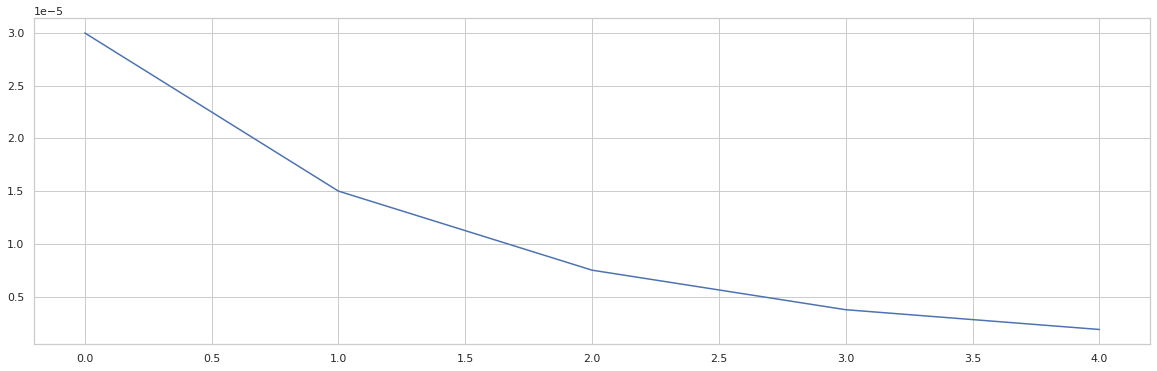

In [6]:
LR_MIN = 1e-6
LR_MAX = config['LEARNING_RATE']
LR_EXP_DECAY = .5

@tf.function
def lrfn(epoch):
    lr = LR_MAX * LR_EXP_DECAY**epoch
    if lr < LR_MIN:
        lr = LR_MIN
    return lr
    
rng = [i for i in range(config['EPOCHS'])]
y = [lrfn(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    last_hidden_state, _  = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    logits = layers.Dense(2, name="qa_outputs", use_bias=False)(last_hidden_state)
    
    start_logits, end_logits = tf.split(logits, 2, axis=-1)
    start_logits = tf.squeeze(start_logits, axis=-1)
    end_logits = tf.squeeze(end_logits, axis=-1)
    
    model = Model(inputs=[input_ids, attention_mask], outputs=[start_logits, end_logits])
    
    return model

# Train

In [8]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    lr_schedule = LearningRateScheduler(lrfn)
    
    
    optimizer = optimizers.Adam(lr=config['LEARNING_RATE'])
    model.compile(optimizer, loss=[losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True),
                                   losses.CategoricalCrossentropy(label_smoothing=0.2, from_logits=True)])

    history = model.fit(list(x_train), list(y_train),
                        validation_data=(list(x_valid), list(y_valid)),
                        batch_size=config['BATCH_SIZE'], 
                        callbacks=[checkpoint, es, lr_schedule],
                        epochs=config['EPOCHS'], 
                        verbose=2).history
    history_list.append(history)
    
    # Make predictions
    # model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train on 21984 samples, validate on 5496 samples
Epoch 1/5
21984/21984 - 285s - loss: 4.4000 - tf_op_layer_Squeeze_loss: 2.1848 - tf_op_layer_Squeeze_1_loss: 2.2151 - val_loss: 4.0697 - val_tf_op_layer_Squeeze_loss: 2.0390 - val_tf_op_layer_Squeeze_1_loss: 2.0303
Epoch 2/5
21984/21984 - 272s - loss: 4.0091 - tf_op_layer_Squeeze_loss: 2.0124 - tf_op_layer_Squeeze_1_loss: 1.9967 - val_loss: 3.9829 - val_tf_op_layer_Squeeze_loss: 2.0039 - val_tf_op_layer_Squeeze_1_loss: 1.9786
Epoch 3/5
21984/21984 - 271s - loss: 3.8937 - tf_op_layer_Squeeze_loss: 1.9645 - tf_op_layer_Squeeze_1_loss: 1.9291 - val_loss: 3.9627 - val_tf_op_layer_Squeeze_loss: 2.0005 - val_tf_op_layer_Squeeze_1_loss: 1.9618
Epoch 4/5
21984/21984 - 271s - loss: 3.8368 - tf_op_layer_Squeeze_loss: 1.9378 - tf_op_layer_Squeeze_1_loss: 1.8990 - val_loss: 3.9523 - val_tf_op_layer_Squeeze_loss: 1.9968 - val_tf_op_layer_Squeeze_1_loss: 1.9551
Epoch 5/5
Restoring model weights from the end of the best epoch.
21984/21984 - 27

# Model loss graph

Fold: 1


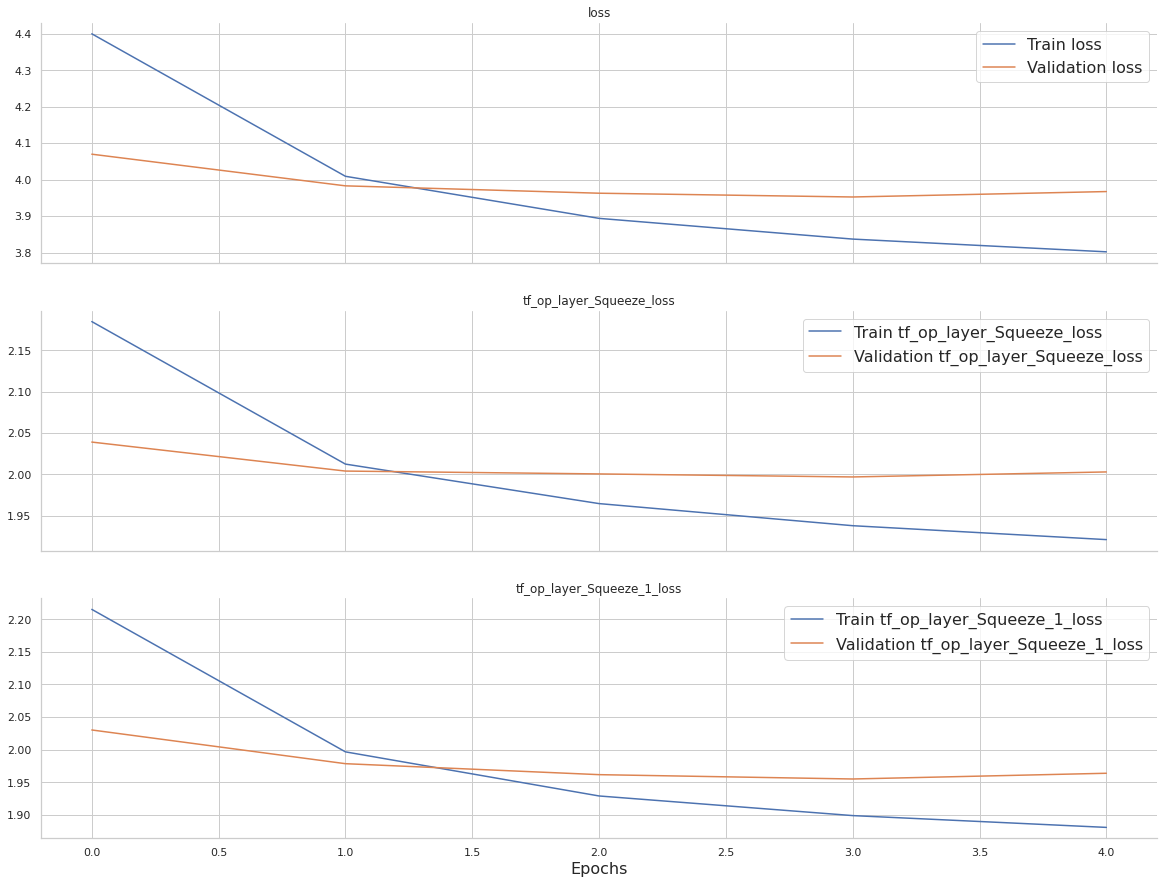

Fold: 2


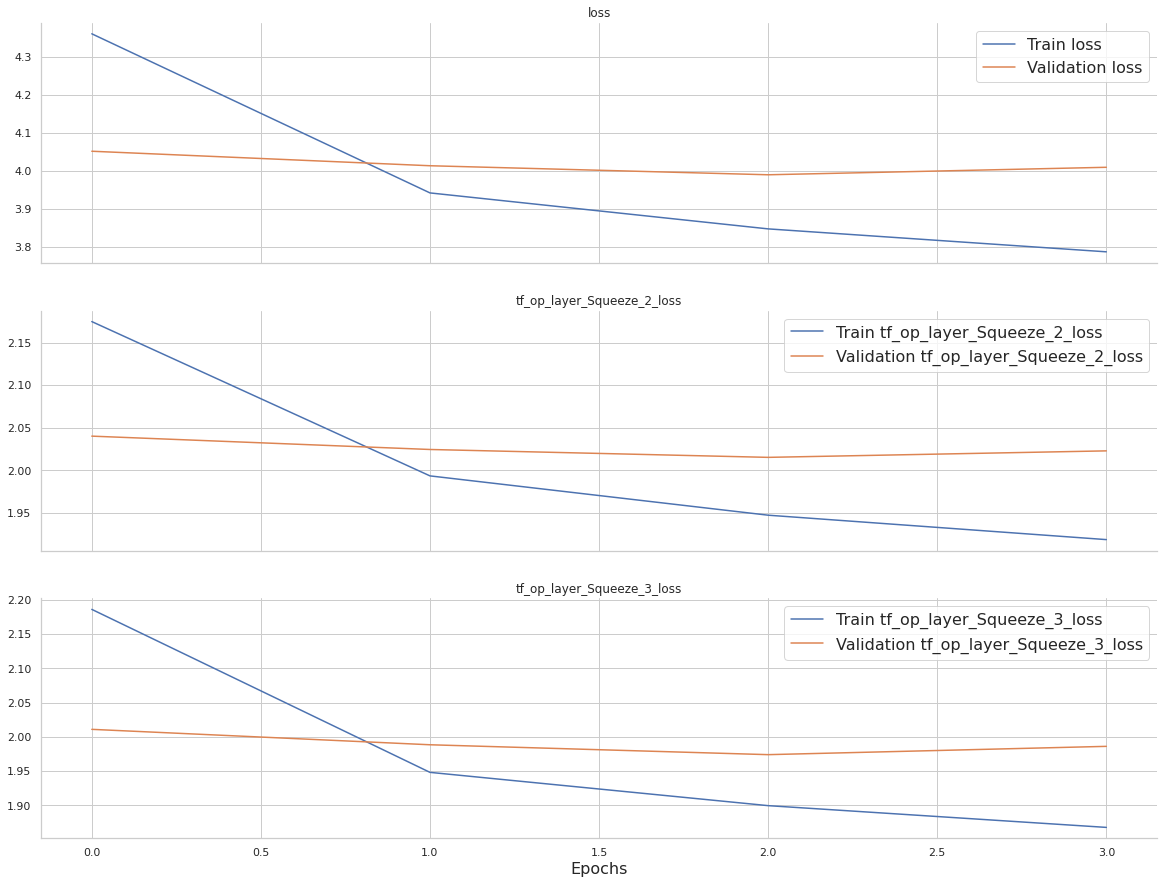

Fold: 3


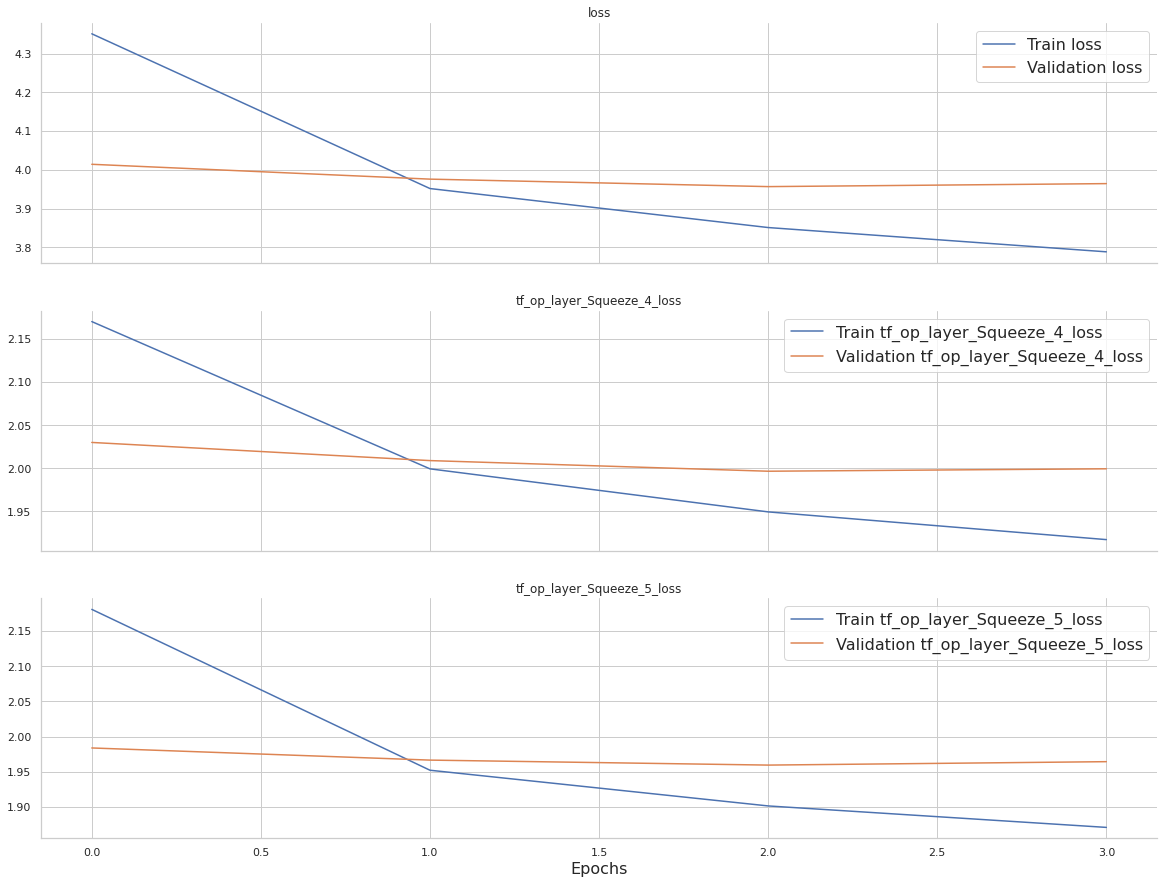

Fold: 4


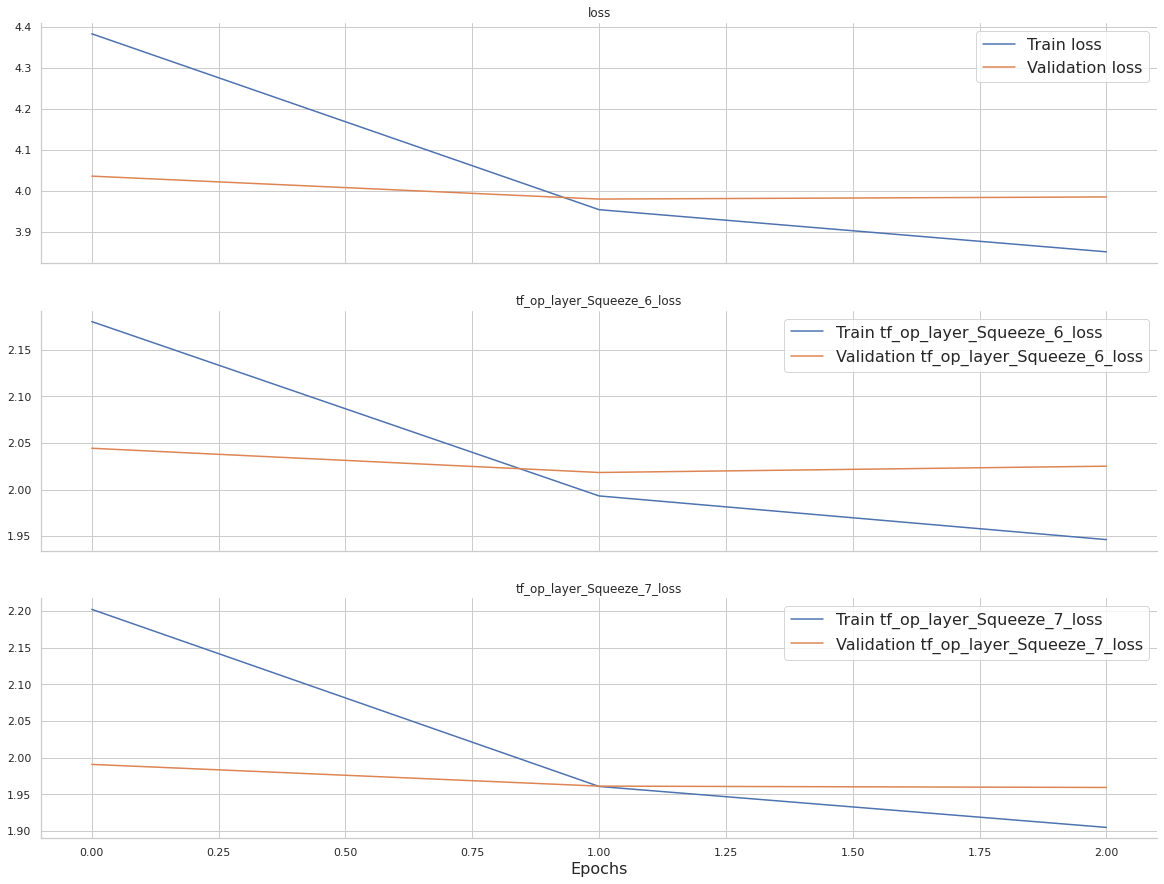

Fold: 5


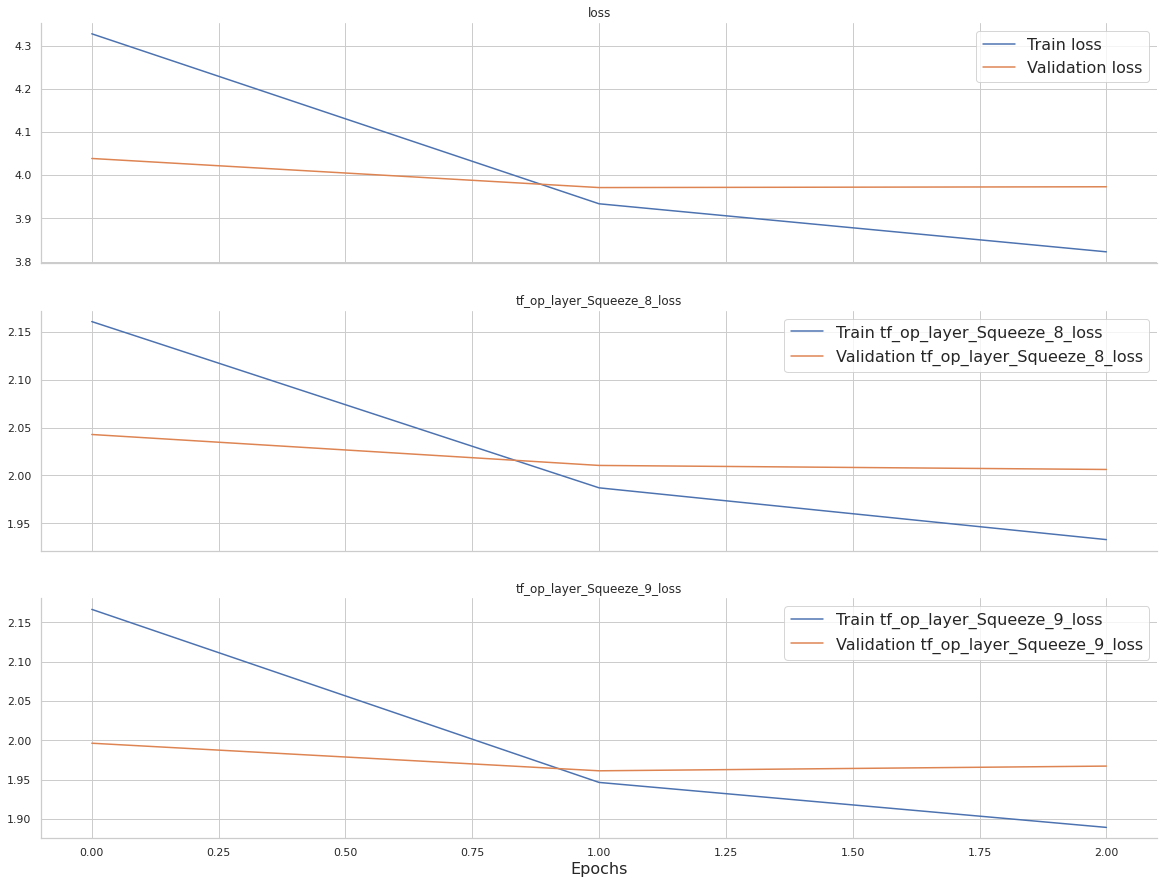

In [9]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [10]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.748715,0.711352,0.037363,0.755150,0.715343,0.754265,0.703380,0.752100,0.722113,0.741025,0.705160,0.741038,0.710766
Sentiment negative,0.598653,0.530960,0.067693,0.610729,0.527074,0.607490,0.522341,0.607193,0.548172,0.581750,0.527907,0.586101,0.529307
Sentiment neutral,0.977666,0.975838,0.001828,0.977254,0.977928,0.977965,0.975761,0.977522,0.976257,0.977941,0.973475,0.977649,0.975771
Sentiment positive,0.588193,0.532296,0.055897,0.598413,0.545737,0.597596,0.514524,0.591454,0.550706,0.578512,0.518406,0.574987,0.532107
0 <= text tokens < 3,0.949906,0.948315,0.001591,0.952083,0.942308,0.951965,0.968254,0.953782,0.962963,0.948661,0.904412,0.943038,0.963636
3 <= text tokens < 15,0.797895,0.769876,0.028020,0.804743,0.766370,0.802077,0.770420,0.800192,0.785982,0.792606,0.765167,0.789858,0.761439
15 <= text tokens < 30,0.719280,0.676895,0.042385,0.726009,0.686618,0.723691,0.669261,0.721034,0.690129,0.711218,0.661687,0.714448,0.676781
30 <= text tokens < 45,0.689972,0.640272,0.049701,0.694860,0.647756,0.701096,0.615905,0.700973,0.630654,0.678381,0.649048,0.674552,0.657995
45 <= text tokens < 120,0.774643,0.728702,0.045940,0.785089,0.720667,0.801350,0.607130,0.735857,0.825930,0.782107,0.673793,0.768812,0.815993


# Visualize predictions

In [11]:
k_fold['jaccard_mean'] = 0

for n in range(config['N_FOLDS']):
    k_fold['jaccard_mean'] += k_fold[f'jaccard_fold_{n+1}'] / config['N_FOLDS']

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean'] + [c for c in k_fold.columns if (c.startswith('prediction_fold'))]].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,10,10,1.000000,1.000000,"i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going"
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,13,3,0.200000,0.700000,sooo sad,sooo sad,sad,sad,sad
2,my boss is bullying me...,bullying me,negative,6,2,0.166667,0.400000,bullying me...,bullying,bullying me...,bullying,bullying me...
3,what interview! leave me alone,leave me alone,negative,6,3,0.600000,1.000000,leave me alone,leave me alone,leave me alone,leave me alone,leave me alone
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,17,4,0.214286,0.866667,"sons of ****,","sons of ****,","sons of ****,","sons of ****,","****,"
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,27,27,1.000000,0.933333,http://www.dothebouncy.com/smf - some shameles...,some shameless plugging for the best rangers f...,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,some shameless plugging for the best rangers f...
6,2am feedings for the baby are fun when he is a...,fun,positive,17,1,0.071429,1.000000,fun,fun,fun,fun,fun
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000,soooo high,soooo high,soooo high,soooo high,soooo high
8,both of you,both of you,neutral,3,3,1.000000,1.000000,both of you,both of you,both of you,both of you,both of you
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,19,7,0.500000,0.200000,wow...,wow...,wow...,wow...,wow...
